# Machine learning : Model Selection

1. [Accuracy](#Accuracy)
1. [Underfitting/Overfitting](#Underfitting/Overfitting)
1. [Cross Validation](#Cross-Validation)

In [1]:
from mllab import *


Packages:
    numpy as np
    matplotlib.pyplot as plt
    pandas as pd

Functions:
    plotXY
    plot_frontiere



>Load [exams.txt](https://who.rocq.inria.fr/Kevin.Zagalo/docs/IMC-4302C/Lab3/exams.txt) in a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and display it.

In [2]:
df = pd.read_csv('exams.txt', delimiter='\t')
df.head(10)

,Exam1,Exam2,result
0,6.92,15.60,rejected
1,6.06,8.78,rejected
2,7.17,14.58,rejected
3,12.04,17.26,accepted
4,15.81,15.07,accepted
5,9.02,11.26,rejected
6,12.22,19.30,accepted
7,15.00,9.31,accepted
8,15.22,17.48,accepted
9,16.89,8.71,accepted


## Accuracy

After training a model, we need to evaluate it. Data being limited, we have no choice but to break our data set into two parts, one for training, the other for testing. One way of scoring a model is to compute its **accuracy**.

>Set a **fixed seed** for your pseudo-random numbers and, build training and testing data sets. Usually we keep 10-30% for testing.
>>Hint : Look at scikit-learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test#sklearn.model_selection.train_test_split).

In [3]:
from sklearn.model_selection import train_test_split

X, y = df[['Exam1', 'Exam2']], df.result

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

> Fit a **logistic regression** model on the training data set. Plot the frontiere between classes.

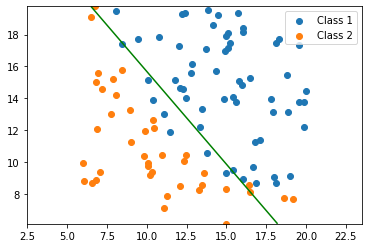

In [4]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression().fit(X_train, y_train)

plotXY(X.values, y.values)
plot_frontiere(LR, X.values)

> Compute the accuracy of your model on your training set : $accuracy = \frac{tp + tn}{size~of~the~sample}$
>> Look at scikit learn's [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function.

In [5]:
from sklearn.metrics import accuracy_score

y_hat = LR.predict(X_train)
accuracy = accuracy_score(y_train, y_hat)
print('Predictions are {:3.1f}% accurate.'.format(100*accuracy))

Predictions are 91.4% accurate.


> Compute the accuracy of your model on your testing set. What is happening ?

In [6]:
y_hat = LR.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)
print('The model is {:3.1f}% accurate.'.format(100*accuracy))

The model is 83.3% accurate.


>Let your data look like this : $$data=[~1, ~f_1,~ f_2,~ f_1^2,~ f_1\times f_2,~ f_2^2]$$
>Hint : Look at scikit-learn's [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit_transform(X[:5].copy())

array([[  1.    ,   6.92  ,  15.6   ,  47.8864, 107.952 , 243.36  ],
       [  1.    ,   6.06  ,   8.78  ,  36.7236,  53.2068,  77.0884],
       [  1.    ,   7.17  ,  14.58  ,  51.4089, 104.5386, 212.5764],
       [  1.    ,  12.04  ,  17.26  , 144.9616, 207.8104, 297.9076],
       [  1.    ,  15.81  ,  15.07  , 249.9561, 238.2567, 227.1049]])

>Train a Logistic Regression model on your training set, and plot **all** results of Exam2 against those of Exam1 and the frontiere between our two classes. 
>>Hint : If you want to use the $\verb!plot_frontiere!$ function you should use a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline).

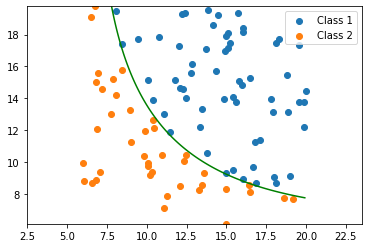

In [8]:
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[('poly', PolynomialFeatures(2)), ('LR', LogisticRegression())])
model.fit(X_train, y_train)

plotXY(X.values, y.values)
plot_frontiere(model, X.values)

> Compute the accuracy of the new model on the testing set.

In [9]:
y_hat = model.predict(X_test)
accuracy = sum(y_hat == y_test)/y_test.shape[0]
print('The model is {:3.1f}% accurate.'.format(100*accuracy))

The model is 100.0% accurate.


## Underfitting/Overfitting

We just saw what is **evaluating** a model, but what is **selecting** a model ? Of course we cannot evaluate and select on the same data set. For example, how can we be sure that the model did not "learn by heart" the data we gave it, and by chance test it on a data set that covers the same range as the training one ?

From that comes the difference between a **testing data set** and a **validation data set**. 

> We generate a $N$-sample : $$\left\{ \begin{array}{ccl} x_i & = & \frac{i}{N} \\ y_i & = & \sin(x_i) + Z_i  \end{array} \right. ~ \mbox{where} ~ Z_i \sim \mathcal{N}(0,1), \forall i \in \{ 1, \dots, N \} , N = 10$$

In [19]:
N = 10
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(size=X.shape)

We want to do a **regression** on a **polynomial transformation** of the features $\left( x_i, i \in \{1,\dots,N\} \right)$, to predict the regressors $\left(y_i, i \in \{1,\dots,N\} \right)$.
>1. Build training and validation sets.
1. Build two-steps models with a **polynomial transformation** of degree $d \in \{1,\dots, 10 \}$ and a **linear regression** estimator.
1. Plot the interpolations and your sample on the same frame.

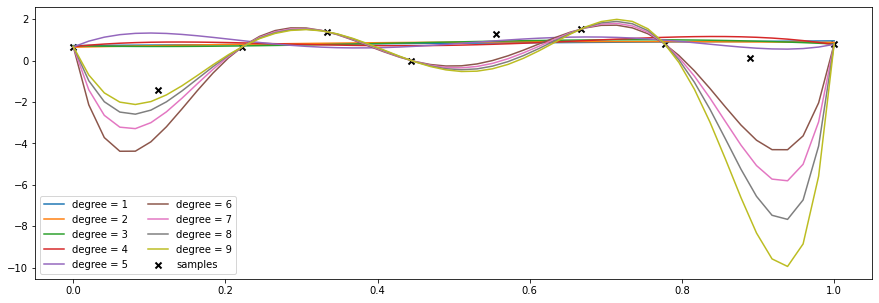

In [20]:
from sklearn.linear_model import LinearRegression

# 1.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)

dict_models = dict()

t = np.linspace(X.min(), X.max()).reshape(-1 ,1)
fig, ax = plt.subplots(figsize=(15, 5))

for d in range(1, 10):
    # 2.
    model = Pipeline(steps=[('poly', PolynomialFeatures(d)), ('LR', LinearRegression())])
    model.fit(X_train, y_train)
    dict_models[d] = model
    
# 3.
    ax.plot(t, model.predict(t), label='degree = %s'%d)
    
ax.scatter(X, y, label='samples', c='black', marker='x', lw=2)
ax.legend(ncol=2)
fig.show()

> Try to find the best degree $d \in \{1,\dots, 10 \}$ for polynomial transformation by
1. Plotting the bias and the variance of your estimators.
1. Plotting the MSE on the train and validation sets on the same frame.

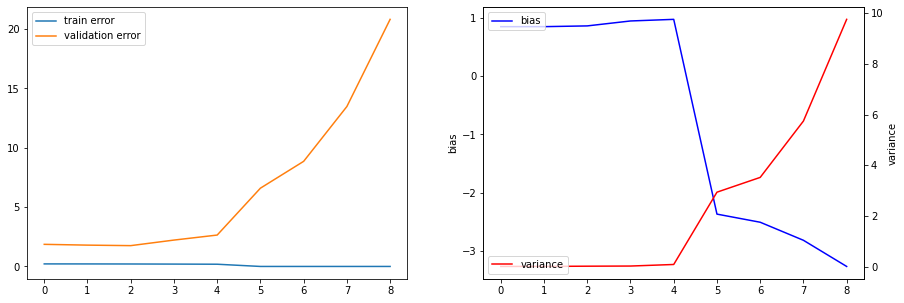

In [21]:
from sklearn.metrics import mean_squared_error as MSE

train_error, val_error = list(), list()
var, bias = list(), list()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
t = np.linspace(X.min(), X.max()).reshape(-1 ,1)

for d, model in dict_models.items():
    model = Pipeline(steps=[('poly', PolynomialFeatures(d)), ('LR', LinearRegression())])
    model.fit(X_train, y_train)

    y_hat0 = model.predict(X_train)
    y_hat1 = model.predict(X_val)
    
    var.append(y_hat1.var())
    bias.append((y_hat1 - y_val).mean())

    train_error.append(MSE(y_train, y_hat0))
    val_error.append(MSE(y_val, y_hat1))

# 4.
ax_1 = ax[1].twinx()
ax[1].plot(bias, c='b', label='bias')
ax[1].set_ylabel('bias')
ax[1].legend(loc='upper left')

ax_1.plot(var, c='r', label='variance')
ax_1.set_ylabel('variance')
ax_1.legend(loc='lower left')

# 5.
ax[0].plot(train_error, label="train error")
ax[0].plot(val_error, label="validation error")
ax[0].legend()

fig.show()

## Cross Validation
>Load [the iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html?highlight=iris%20dataset#sklearn.datasets.load_iris) in a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and display it.

In [1]:
from sklearn.datasets import load_iris

dataset = load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [23]:
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.DataFrame(dataset.target, columns=['target'])

pd.concat([X, y], axis=1).head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


> Scatter every $6=\frac{4!}{2!2!}$ combination of 2 features, one against the other, each class with a different color.
>> Hint : Use $\verb!plotXY!$.

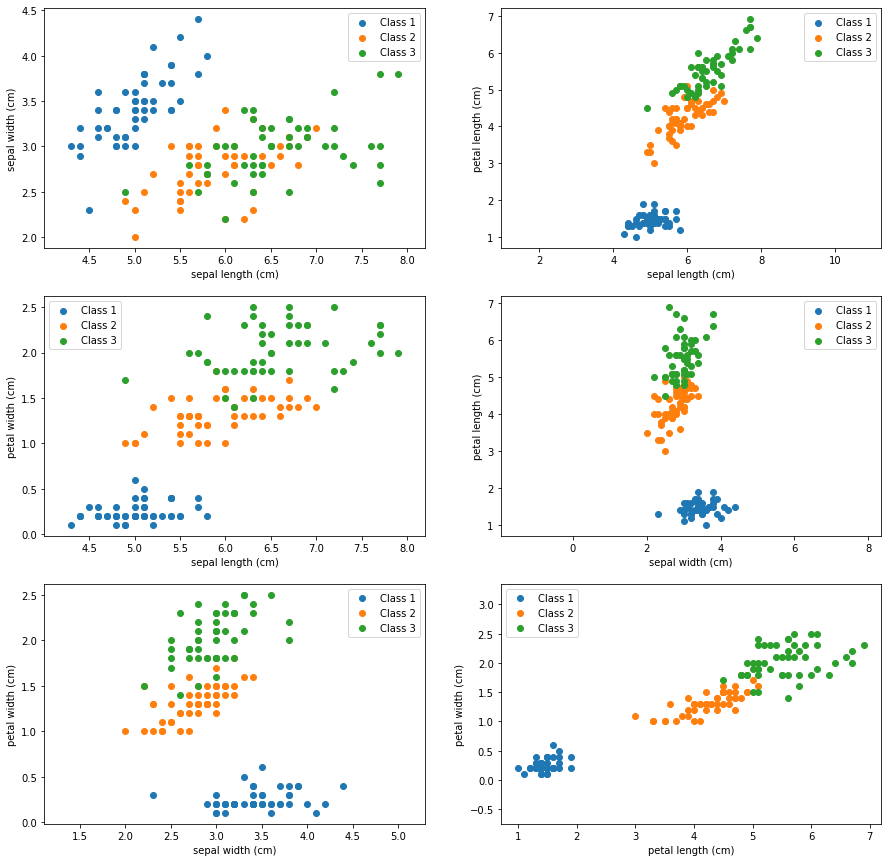

In [24]:
from itertools import combinations

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for (xx, yy), ax_ in zip(combinations(X.columns, 2), ax.reshape(6)):
    ax_ = plotXY(X[[xx, yy]].values, y.target.values, ax=ax_)
    ax_.set_xlabel(xx)
    ax_.set_ylabel(yy)
fig.show()

> - Add a $2$-polynomial transformation to the model.
- **Split** the data into train and test sets, **without fixing a seed** (random state). Train a [linear discriminant analysis](sklearn.discriminant_analysis.LinearDiscriminantAnalysis) model and compute its accuracy.
- Do it serval times and plot the evolution. What do you observe ?

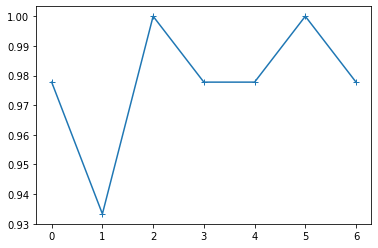

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

n_splits = 7
accuracy = list()

for _ in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    model = Pipeline(steps=[('poly', PolynomialFeatures(2)), ('lda', LDA())])
    y_hat = model.fit(X_train, y_train).predict(X_test)
    
    accuracy.append(accuracy_score(y_test, y_hat))

plt.plot(accuracy, marker='+')
plt.show()

>Split your data into training and testing sets with a **fixed random state**, with ratio 70%/30%.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

>- Split you training set into 5 partitions. You may use scikit-learn's [Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) with a **fixed random state**.
- For each part, train a **linear discriminant analysis** on the 4 other parts (training) and compute its **accuracy** on it (validation). 
- Compute the **mean accuracy** (bootstrap) for each partition.
- Do it several times (7~8) and plot the evolution. What do you observe ?

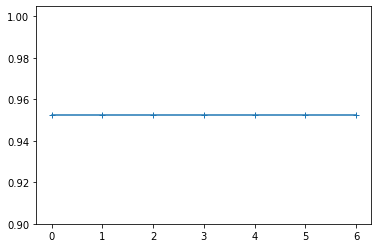

In [27]:
from sklearn.model_selection import KFold

mean_accuracy = list()

#4
for _ in range(7):
    accuracy = list()

    #1
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val = X_train.values[train_index], X_train.values[val_index]
        y_train_kf, y_val = y_train.values[train_index], y_train.values[val_index]

        #2
        model = Pipeline(steps=[('poly', PolynomialFeatures(2)), ('lda', LDA())])
        y_hat = model.fit(X_train_kf, y_train_kf).predict(X_val)

        accuracy.append(accuracy_score(y_val, y_hat))
    #3
    mean_accuracy.append(np.mean(accuracy))
    
plt.plot(mean_accuracy, marker='+')
plt.show()

> Do the same for several degrees of $d$-polynomial transformation and plot the evolution of the mean accuracy against the values of $d \in \{1,\dots,5\}$.

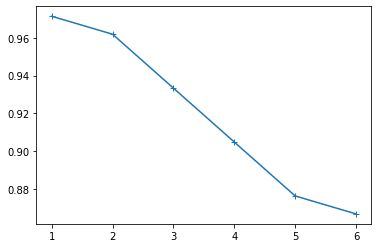

In [28]:
mean_accuracy = list()

for d in range(1, 7):
    accuracy = list()

    #2
    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val = X_train.values[train_index], X_train.values[val_index]
        y_train_kf, y_val = y_train.values[train_index], y_train.values[val_index]


        model = Pipeline(steps=[('poly', PolynomialFeatures(d)), ('lda', LDA())])
        y_hat = model.fit(X_train_kf, y_train_kf).predict(X_val)

        accuracy.append(accuracy_score(y_val, y_hat))

    mean_accuracy.append(np.mean(accuracy))

plt.plot(range(1, 7), mean_accuracy, marker='+')
plt.show()

> Do the same with a **logistic regression**. Compare the results. Which model do you chose ? Why ?

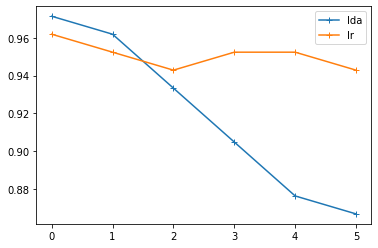

In [35]:
for clf_name, clf in ('lda', LDA()), ('lr', LogisticRegression()):
    mean_accuracy = list()
    for d in range(1, 7):
        accuracy_val = list()

        #2
        kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

        for train_index, val_index in kf.split(X_train):
            X_train_kf, X_val = X_train.values[train_index], X_train.values[val_index]
            y_train_kf, y_val = y_train.values[train_index], y_train.values[val_index]

            model = Pipeline(steps=[('poly', PolynomialFeatures(d)), (clf_name, clf)])
            y_hat = model.fit(X_train_kf, y_train_kf).predict(X_val)

            accuracy_val.append(accuracy_score(y_val, y_hat))

        mean_accuracy.append(np.mean(accuracy_val))
            
    plt.plot(mean_accuracy, marker='+', label=clf_name)
plt.legend()
plt.show()